2) Необходимо подготовить код реализующий классификацию датасета CIFAR10 с точностью >50%, на примере этого кода
https://colab.research.google.com/drive/1B6i5Z2glYz5Bnew4D2U60iUlbnLSMlUt



In [0]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import datetime
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision import datasets, transforms

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=20, kernel_size=5, padding=0, stride=1)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, padding=0, stride=1)

        self.fc1 = nn.Linear(5*5*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2) 
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 5*5*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
      
def read_settings():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=15, metavar='N',
                        help='number of epochs to train (default: 10)')
    parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                        help='learning rate (default: 0.01)')
    parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                        help='SGD momentum (default: 0.5)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=40, metavar='N',
                        help='how many batches to wait before logging training status')

    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    
    args = parser.parse_args([])
    use_cuda = not args.no_cuda and torch.cuda.is_available()
    print('use_cuda : {}'.format(use_cuda))
    
    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    return args, kwargs, device

def load_dataset(args,kwargs):
    # CIFAR10.
    train_dataset = datasets.CIFAR10('data', 
                                      train=True, 
                                      download=True, 
                                      transform=transforms.ToTensor())

    test_dataset = datasets.CIFAR10('data', 
                                     train=False, 
                                     transform=transforms.ToTensor())
    print(len(train_dataset),len(test_dataset),type(test_dataset))
    
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=args.batch_size, 
                                               shuffle=True, 
                                               **kwargs)
    test_loader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=args.test_batch_size,
                                              shuffle=True, 
                                              **kwargs)
    print(train_loader.dataset.data.shape)
    print(test_loader.dataset.data.shape)
    
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']
    
    for data, target in train_loader:
        break
    print(data.shape)
    print(data[0].shape)
    plt.figure(figsize=(12,5))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.axis('off')
        plt.title(classes[target[i]])
        plt.imshow(data[i].permute(1, 2, 0))
    return train_loader, test_loader

def main():
#     parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    args, kwargs, device = read_settings()
    train_loader, test_loader = load_dataset(args, kwargs)
    
    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(args, model, device, test_loader)

    if (args.save_model):
        torch.save(model.state_dict(),"my_cifar_cnn.pt")
    


0it [00:00, ?it/s]

use_cuda : False


170500096it [00:03, 54250826.01it/s]                               


50000 10000 <class 'torchvision.datasets.cifar.CIFAR10'>
(50000, 32, 32, 3)
(10000, 32, 32, 3)
torch.Size([64, 3, 32, 32])
torch.Size([3, 32, 32])
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.302028
Train Epoch: 1 [2560/50000 (5%)]	Loss: 2.297599
Train Epoch: 1 [5120/50000 (10%)]	Loss: 2.299407
Train Epoch: 1 [7680/50000 (15%)]	Loss: 2.291301
Train Epoch: 1 [10240/50000 (20%)]	Loss: 2.283412
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.261635
Train Epoch: 1 [15360/50000 (31%)]	Loss: 2.235602
Train Epoch: 1 [17920/50000 (36%)]	Loss: 2.206543
Train Epoch: 1 [20480/50000 (41%)]	Loss: 2.212744
Train Epoch: 1 [23040/50000 (46%)]	Loss: 2.111432
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.050973
Train Epoch: 1 [28160/50000 (56%)]	Loss: 2.065545
Train Epoch: 1 [30720/50000 (61%)]	Loss: 2.019655
Train Epoch: 1 [33280/50000 (66%)]	Loss: 1.942475
Train Epoch: 1 [35840/50000 (72%)]	Loss: 2.017783
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.957595
Train Epoch: 1 [40960/50000 (82%)]	Loss: 1.865553
Train Epoch:

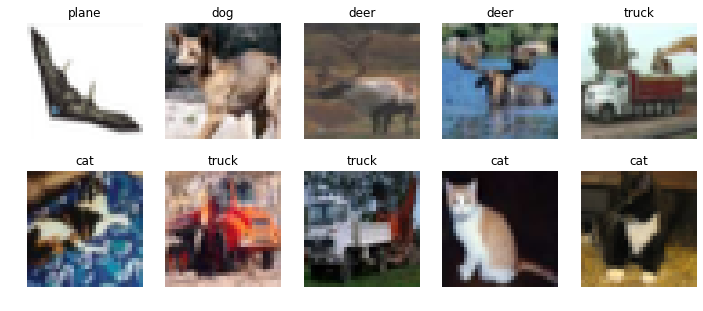

In [0]:
main()